# DeepRacer image analysis for evaluation criteria

In [2]:
import itertools
import json
import math
from PIL import Image
from PIL import ImageEnhance
from PIL import ImageFilter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import s3_models
import skimage
import skimage.exposure
import tensorflow as tf
from tensorflow.python.platform import gfile

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def image_to_npy(image_path):
    img = Image.open(image_path)
#    img = img.resize((84,84)) # only use for shallow network
    img_arr = np.array(img)
    img_arr = rgb2gray(img_arr)
    img_arr = np.expand_dims(img_arr, axis=2)
    return img_arr

def image_grid(image_paths):
    plt.figure(1, figsize=(20,20))
    n_columns = 5
    n_rows = math.ceil(len(eval_images) / n_columns) + 1
    for i in range(len(image_paths)):
        plt.subplot(n_rows, n_columns, i+1)
        image_path = image_paths[i]
        plt.title(image_path)
        image = np.array(Image.open(image_path))
        plt.imshow(image, interpolation="nearest", cmap="gray")

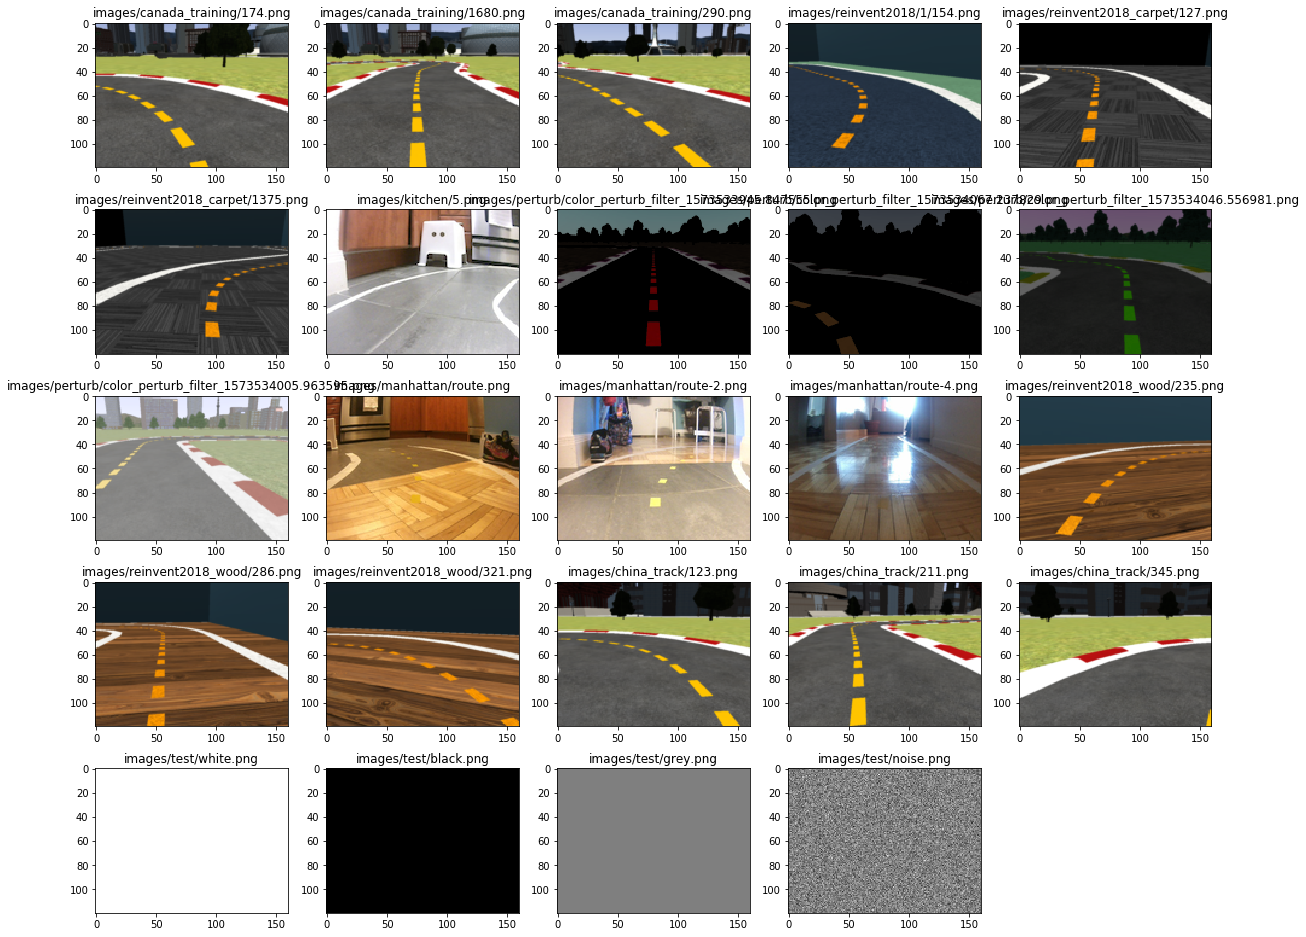

In [4]:
# Categorization
LEFT=0
STRAIGHT=1
RIGHT=2
MIXED=3 # This is a turn where the bottom 3rd of the image suggests different
        # action than the middle third
TEST=4  # Test image that should return flat probabilities

eval_images = np.array([
#    ['images/canada_training/1324.png', RIGHT],
    ['images/canada_training/174.png', LEFT],
    ['images/canada_training/1680.png', STRAIGHT],
    ['images/canada_training/290.png',LEFT],
    ['images/reinvent2018/1/154.png', LEFT],
#    ['images/reinvent2019/1/1714.png',LEFT],
    ['images/reinvent2018_carpet/127.png', STRAIGHT],
    ['images/reinvent2018_carpet/1375.png', RIGHT],
    ['images/kitchen/5.png', RIGHT],
    ['images/perturb/color_perturb_filter_1573533945.847555.png', STRAIGHT], # hue and contrast
    ['images/perturb/color_perturb_filter_1573534067.237829.png', LEFT], # brightness
    ['images/perturb/color_perturb_filter_1573534046.556981.png', STRAIGHT], # hue and brightness
    ['images/perturb/color_perturb_filter_1573534005.963595.png', STRAIGHT], # brightness
    ['images/manhattan/route.png', LEFT], # transition in flooring: light->dark
    ['images/manhattan/route-2.png', RIGHT], # transition in flooring: dark->light
#    ['images/manhattan/route-3.png', RIGHT],  # heavy reflections
    ['images/manhattan/route-4.png', STRAIGHT], # heavy reflections
    ['images/reinvent2018_wood/235.png', RIGHT],
    ['images/reinvent2018_wood/286.png', STRAIGHT],
    ['images/reinvent2018_wood/321.png', LEFT],
    ['images/china_track/123.png', LEFT],
    ['images/china_track/211.png', STRAIGHT],
    ['images/china_track/345.png', RIGHT],
    ['images/test/white.png', TEST],
    ['images/test/black.png', TEST],
    ['images/test/grey.png', TEST],
    ['images/test/noise.png', TEST]
])

image_grid(eval_images[:,0:1].flatten())

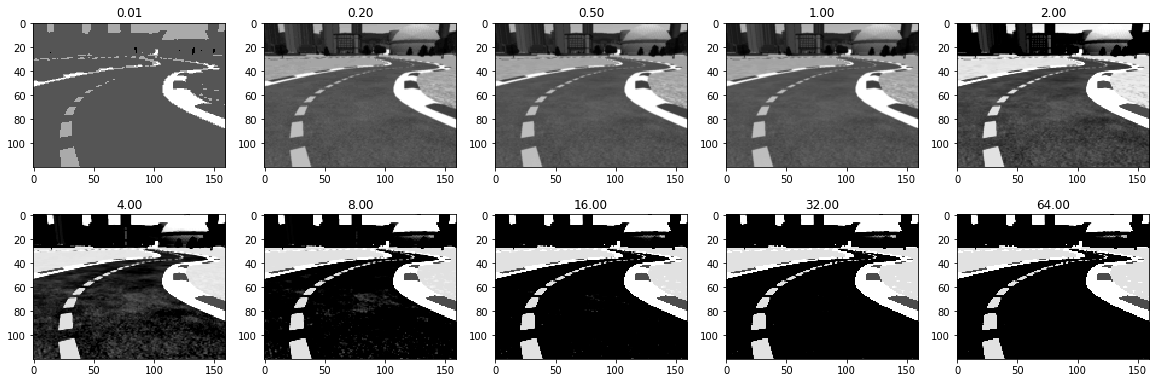

In [5]:
# Contrast levels to test feature extraction

image_path = 'images/canada_training/1324.png' # exiting turn
#image_path = 'images/kitchen/5.png'


contrast_levels = [0.01, 0.2, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0]
original = Image.open(image_path)
plt.figure(1, figsize=(20,10))
n_columns = 5
n_rows = math.ceil(len(contrast_levels) / n_columns) + 1
for i in range(len(contrast_levels)):
    contrast = ImageEnhance.Contrast(original).enhance(contrast_levels[i])
    contrast = contrast.convert('L')
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('%0.2f' % contrast_levels[i])
    plt.imshow(contrast, interpolation="nearest", cmap="gray")

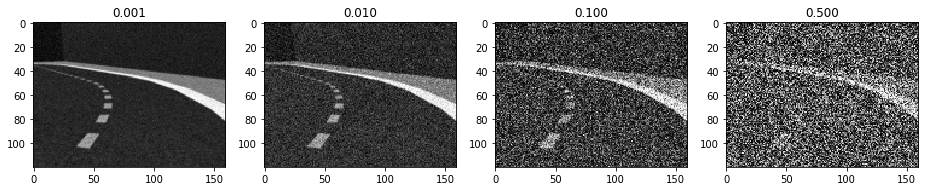

In [6]:
# Noise levels to test feature extraction

image_path = 'images/reinvent2018/1/154.png'

noise_levels = [0.001, 0.01, 0.1, 0.5]
original = Image.open(image_path)
plt.figure(1, figsize=(20,10))
n_columns = 5
n_rows = math.ceil(len(noise_levels) / n_columns) + 1
for i in range(len(noise_levels)):
#    image = original.convert('L')
    gaussian = skimage.util.random_noise(np.array(original), var=noise_levels[i])
    gaussian = rgb2gray(gaussian)
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('%0.3f' % noise_levels[i])
    plt.imshow(gaussian, interpolation="nearest", cmap="gray")


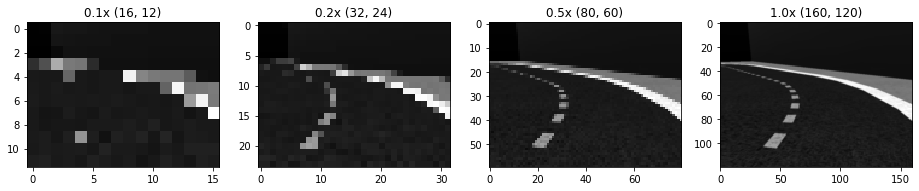

In [7]:
# Downscaling to remove details

image_path = 'images/reinvent2018/1/154.png'

scale_levels = [0.1, 0.2, 0.5, 1.0]
original = Image.open(image_path)
plt.figure(1, figsize=(20,10))
n_columns = 5
n_rows = math.ceil(len(scale_levels) / n_columns) + 1
for i in range(len(scale_levels)):
    size = (int(original.size[0] * scale_levels[i]), int(original.size[1] * scale_levels[i]))
    #print("Scaling %r to %r", (original.size, size))
    scaled = original.resize(size)
    scaled = rgb2gray(np.array(scaled))
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('%0.1fx %r' % (scale_levels[i], size))
    plt.imshow(scaled, interpolation="nearest", cmap="gray")

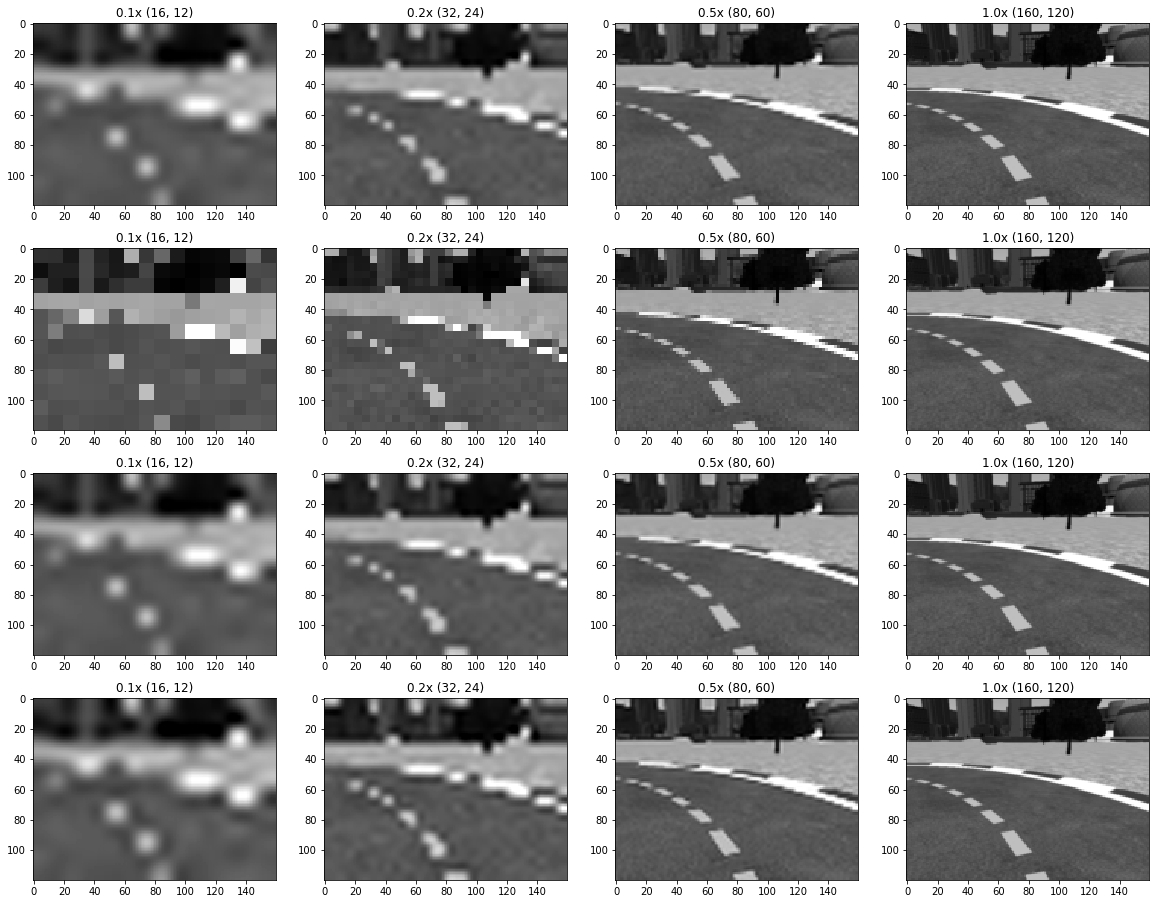

In [8]:
# Downscaling+Upscaling to remove details

#image_path = 'images/reinvent2018/1/154.png'
#image_path = 'images/manhattan/route-2.png'
image_path = 'images/canada_training/174.png'


scale_levels = [0.1, 0.2, 0.5, 1.0]
resamples = [Image.BICUBIC, Image.NEAREST, Image.BICUBIC, Image.LANCZOS]
original = Image.open(image_path)
plt.figure(1, figsize=(20,20))
n_columns = len(scale_levels)
n_rows = math.ceil(len(scale_levels) * len(resamples) / n_columns) + 1
for j in range(len(resamples)):
    for i in range(len(scale_levels)):
        size = (int(original.size[0] * scale_levels[i]), int(original.size[1] * scale_levels[i]))
        scaled = original.resize(size)
        # Can be Image.BICUBIC, Image.NEAREST, Image.BICUBIC, Image.LANCZOS
        scaled = scaled.resize(original.size, resamples[j])
        scaled = rgb2gray(np.array(scaled))
        plt.subplot(n_rows, n_columns, (j*n_columns) + i + 1)
        plt.title('%0.1fx %r' % (scale_levels[i], size))
        plt.imshow(scaled, interpolation="nearest", cmap="gray")

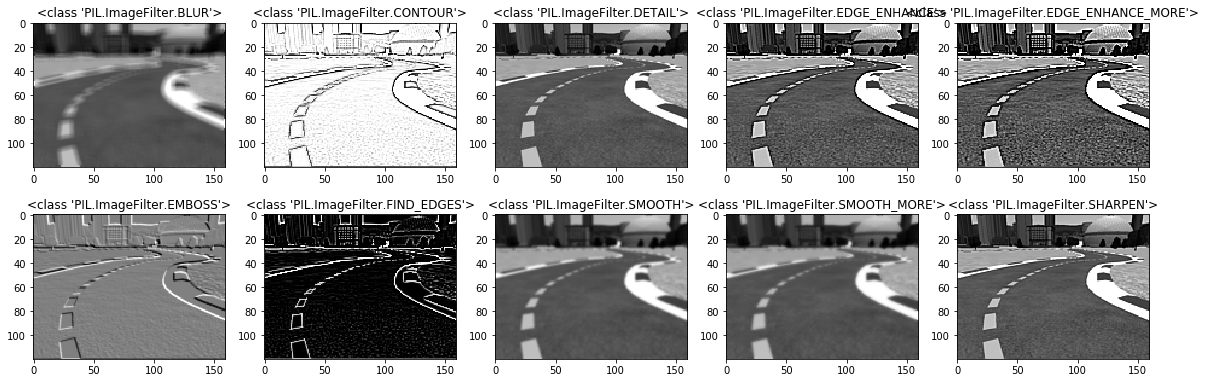

In [9]:
# Filtering

image_path = 'images/canada_training/1324.png' # exiting turn
#image_path = 'images/kitchen/5.png'

filters = [ImageFilter.BLUR,
           ImageFilter.CONTOUR,
           ImageFilter.DETAIL,
           ImageFilter.EDGE_ENHANCE,
           ImageFilter.EDGE_ENHANCE_MORE,
           ImageFilter.EMBOSS,
           ImageFilter.FIND_EDGES,
           ImageFilter.SMOOTH,
           ImageFilter.SMOOTH_MORE,
           ImageFilter.SHARPEN]

original = Image.open(image_path)
plt.figure(1, figsize=(20,10))
n_columns = 5
n_rows = math.ceil(len(filters) / n_columns) + 1
for i in range(len(filters)):
    filtered = original.filter(filters[i])
    filtered = filtered.convert('L')
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('%r' % filters[i])
    plt.imshow(filtered, interpolation="nearest", cmap="gray")

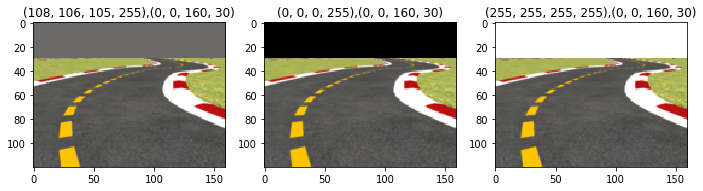

In [10]:
# Masking - Fixed

image_path = 'images/canada_training/1324.png' # exiting turn
#image_path = 'images/kitchen/5.png'

TRAINING_IMAGE_SIZE = (160, 120)
fill_colors = [(108,106,105,255), (0,0,0,255), (255,255,255,255)]
fill_areas = [(0,0,160,30)]

original = Image.open(image_path)
plt.figure(1, figsize=(20,10))
n_columns = 5
n_rows = math.ceil(len(fill_colors) * len(fill_areas) / n_columns) + 1
i = 0
for c,a in itertools.product(fill_colors, fill_areas):
    masked = original.copy()
    masked.paste(c, box=a)
    filtered = masked.convert('L')
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('%r,%r' % (c,a))
    plt.imshow(masked, interpolation="nearest", cmap="gray")
    i += 1

v_a dtype  uint8
v_a dtype  float64


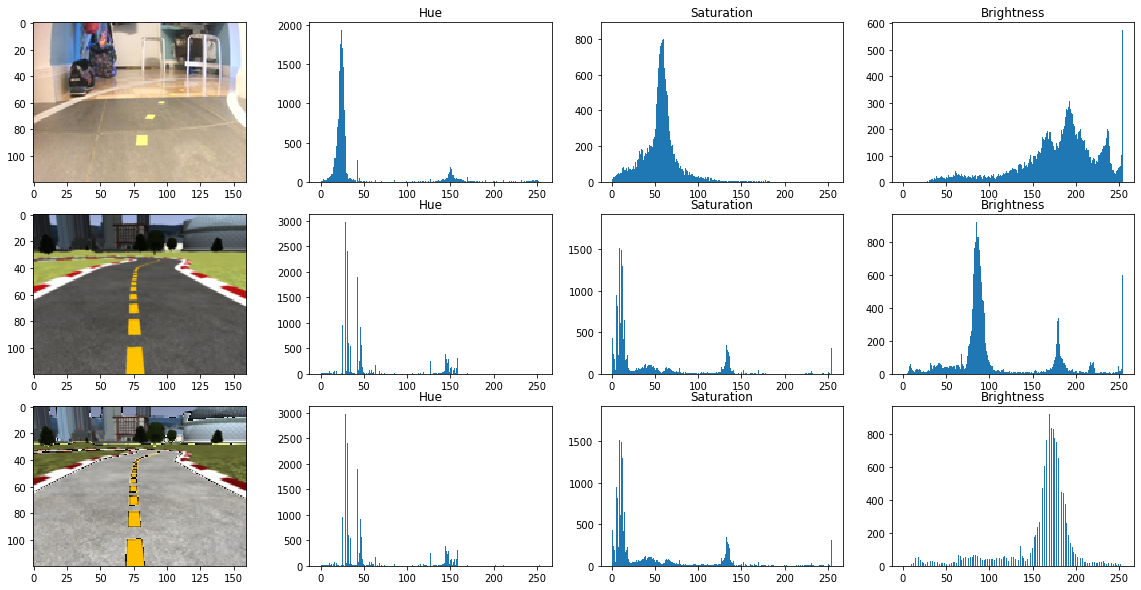

In [20]:
# Spectrum analysis

plt.figure(1, figsize=(20,10))

# Physical camera
image_path = 'images/manhattan/route-2.png'
original = Image.open(image_path)
hsv = original.convert(mode='HSV')
h,s,v = hsv.split()
plt.subplot(3, 4, 1)
plt.imshow(original, interpolation="nearest", cmap="gray")
plt.subplot(3, 4, 2)
plt.title("Hue")
c, e, p = plt.hist(np.array(h).flatten(), bins=256, range=(0,255))
plt.subplot(3, 4, 3)
plt.title("Saturation")
c, e, p = plt.hist(np.array(s).flatten(), bins=256, range=(0,255))
plt.subplot(3, 4, 4)
plt.title("Brightness")
c, e, p = plt.hist(np.array(v).flatten(), bins=256, range=(0,255))

# Simulation camera
image_path = 'images/canada_training/1680.png'
original = Image.open(image_path)
hsv = original.convert(mode='HSV')
h,s,v = hsv.split()
plt.subplot(3, 4, 5)
plt.imshow(original, interpolation="nearest", cmap="gray")
plt.subplot(3, 4, 6)
plt.title("Hue")
c, e, p = plt.hist(np.array(h).flatten(), bins=256, range=(0,255))
plt.subplot(3, 4, 7)
plt.title("Saturation")
c, e, p = plt.hist(np.array(s).flatten(), bins=256, range=(0,255))
plt.subplot(3, 4, 8)
plt.title("Brightness")
c, e, p = plt.hist(np.array(v).flatten(), bins=256, range=(0,255))


# Adjusted simulation camera
image_path = 'images/canada_training/1680.png'
original = Image.open(image_path)
hsv = original.convert(mode='HSV')
h,s,v = hsv.split()

v_a = np.array(v)
print("v_a dtype ", v_a.dtype)
v_a = v_a * 1.0 # implicit conversion to dtype=float64
print("v_a dtype ", v_a.dtype)

new_v = Image.fromarray(v_a.astype('uint8'), 'L')
merged = Image.merge('HSV', (h,s,new_v))
merged = merged.convert('RGB')
plt.subplot(3, 4, 9)
plt.imshow(merged, interpolation="nearest", cmap="gray")
plt.subplot(3, 4, 10)
plt.title("Hue")
c, e, p = plt.hist(np.array(h).flatten(), bins=256, range=(0,255))
plt.subplot(3, 4, 11)
plt.title("Saturation")
c, e, p = plt.hist(np.array(s).flatten(), bins=256, range=(0,255))
plt.subplot(3, 4, 12)
plt.title("Brightness")
c, e, p = plt.hist(v_a.flatten(), bins=256, range=(0,255))


# Offline Evaluation

In [82]:
s3_bucket='aws-deepracer-b6c3c104-eef5-4878-a257-d981cd204d62'


# tiberius session3a
#job_id='20191114030939-14ad716e-bcad-465c-87b1-117a2e718f88'

# nero session1
#job_id='20191121194910-d7442c81-7966-4ed3-bf23-22d93fcfbed3'
# nero session1a
#job_id='20191122140743-8e69f32d-3ed4-4ef9-ab78-1c338bcdb59f'
# nero session1b
#job_id='20191124123204-f86d7945-d893-43fe-ae92-9be63442f736'
# nero session1c (shallow network with OOM issues)
#job_id='20191124225016-bdc2909c-e270-47e2-84d3-97084b68ef12'
# nero session1d
#job_id='20191125220919-8e5a9da1-9d2d-410f-8c51-fd19bf7d75d6'
# nero session1e
#job_id='20191126232543-1d063616-b927-4eab-8fe1-e3627a955d20'

# galba session1
#job_id='20191128021150-74c993f8-98d8-46d0-be59-e6736942d664'
# galba session2
#job_id='20191128052645-ff18cb68-cbcd-4448-8ac0-41513cbfba73'
# galba session3
#job_id='20191207171918-44d0924f-f9d6-464e-b74f-32944de8344c'
# galba session3a
#job_id='20191208005604-1427b7f7-2119-4308-b0a3-69cbbb9189a7'
# galba session3b
#job_id='20191208021239-edcbf3f2-8b5e-4896-9b15-553eb9054daa'
# galba session3b2
job_id='20191208164910-49e15884-21d2-43dc-9a95-c6ba95581d2b'

s3_prefix='training-jobs/%s/shared/model' % job_id
log_path='models/%s' % job_id
print("Available checkpoints to load")
available_checkpoints = s3_models.list_available_checkpoints(s3_bucket, s3_prefix, log_path)
available_checkpoints = sorted(available_checkpoints, key=lambda name: int(name[6:].split('.')[0])) # sort numerically
print("%d checkpoints available for %s (%s is latest)" % (len(available_checkpoints), job_id, available_checkpoints[-1]))

Available checkpoints to load


IndexError: list index out of range

In [78]:
# Functions to load graph and run an image through inference

def load_session(pb_path):
    # allow_soft_placement will avoid errors when loading the graph without a GPU
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, 
                                    log_device_placement=True))
    #print("load graph:", pb_path)
    with gfile.FastGFile(pb_path,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    sess.graph.as_default()  # set this as the default graph for the session
    tf.import_graph_def(graph_def, name='')
    observation_tensor = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/observation/observation:0')
    policy_tensor = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')    
    return sess, observation_tensor, policy_tensor

# Run inference, returning the action probabilities
def analyze_image(model, observation_tensor, policy_tensor, image_path):
    img_arr = image_to_npy(image_path)
    # Note that the input image should already be scaled as expected by the network observation layer
    return model.run(policy_tensor, feed_dict={observation_tensor:[img_arr]})[0]

In [79]:
# Evaluation cycle
#
# 1) Download model and metadata files from S3
# 2) Run evaluation images and measure:
#    a) confidence rating (model should prefer one action over others)
#    b) action rating (should it turn left?)
# 3) (maybe) 
# 4) (TBD) Launch RoboMaker lap evaluations


def evaluate(checkpoint):
    # Load the model into tensorflow
    tf.reset_default_graph()
    model_path = s3_models.download_checkpoint(s3_bucket, s3_prefix, "model_%d.pb" % checkpoint, log_path)
    actions_path = s3_models.download_actions(s3_bucket, s3_prefix, log_path)
    # for PPO we need the number of discrete outputs
    with open(actions_path, "r") as f:
        action_space = json.load(f)['action_space']
    number_of_actions = len(action_space)
    #display(action_space)
    # load the model
    model, obs, policy = load_session(model_path)

    # evaluate
    results = list()
    tests = list() # specifically for test images which should be LOW confidence
    confidence = 0.0
    for i in range(len(eval_images)):
        image_path, action_category = eval_images[i]
        probs = analyze_image(model, obs, policy, image_path)
        action_index = np.argmax(probs) # find the action corresponding to the index
        action = [a for a in action_space if a['index'] == action_index][0]
        #print("action is %r" % action)
        result = [image_path, np.mean(probs), np.std(probs), np.max(probs), probs]
        #print("evaluating %s for category %r" % (image_path, action_category))
        if int(action_category) == TEST:
            tests.append(result)
        else:
            steer = action['steering_angle']
            if action['steering_angle'] > 0:
                steer = LEFT
            elif action['steering_angle'] == 0:
                steer = STRAIGHT
            else:
                steer = RIGHT
            accuracy = 1.0 - abs(steer - int(action_category)) * 0.5   # 1 if equal, 0.5 if adjacent, else 0
            result.append(accuracy)
            results.append(result)

    # Thoughts on confidence metric:
    #  - high max is great, single choice is good
    #  - lower max can be ok if probs are adjacent and stdev is not too small
    #display(results)
    confidence = np.mean(np.array(results)[:,3]) # get max probs
    confidence_std = np.std(np.array(results)[:,3])
    accuracy = np.mean(np.array(results)[:,5])
    accuracy_std = np.std(np.array(results)[:,5])
    display("Confidence Score %0.3f with accuracy %0.3f for %d images" % (confidence, accuracy, len(results)))
    # clean up
    model.close()
    return confidence, confidence_std, accuracy, accuracy_std


In [80]:
c_score = list()
c_std = list()
a_score = list()
a_std = list()
for i in range(len(s3_models.list_available_checkpoints(s3_bucket, s3_prefix, log_path))):
    try:
        confidence, confidence_std, accuracy, accuracy_std = evaluate(i)
        c_score.append(confidence)
        c_std.append(confidence_std)
        a_score.append(accuracy)
        a_std.append(accuracy_std)
    except Exception as e:
        # stop if failed to evaluate, probably when we've reached the final checkpoint
        print("Stopping on %i: %r" % (i, e))
        break

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



'Confidence Score 0.772 with accuracy 0.750 for 20 images'

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



'Confidence Score 0.812 with accuracy 0.800 for 20 images'

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



'Confidence Score 0.829 with accuracy 0.775 for 20 images'

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



'Confidence Score 0.818 with accuracy 0.775 for 20 images'

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



'Confidence Score 0.868 with accuracy 0.750 for 20 images'

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



'Confidence Score 0.879 with accuracy 0.750 for 20 images'

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



'Confidence Score 0.902 with accuracy 0.750 for 20 images'

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



'Confidence Score 0.874 with accuracy 0.750 for 20 images'

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



'Confidence Score 0.861 with accuracy 0.750 for 20 images'

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



'Confidence Score 0.842 with accuracy 0.750 for 20 images'

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



'Confidence Score 0.809 with accuracy 0.850 for 20 images'

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



'Confidence Score 0.899 with accuracy 0.775 for 20 images'

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



'Confidence Score 0.897 with accuracy 0.750 for 20 images'

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



'Confidence Score 0.939 with accuracy 0.725 for 20 images'

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



'Confidence Score 0.907 with accuracy 0.750 for 20 images'

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



'Confidence Score 0.941 with accuracy 0.725 for 20 images'

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



'Confidence Score 0.957 with accuracy 0.725 for 20 images'

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



'Confidence Score 0.925 with accuracy 0.700 for 20 images'

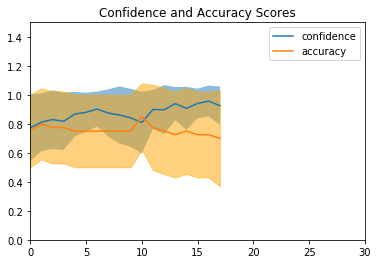

In [81]:
plt.plot(np.arange(len(c_score)), c_score, label="confidence")
plt.fill_between(np.arange(len(c_std)), np.array(c_score) + np.array(c_std), np.array(c_score) - np.array(c_std), alpha=0.5)
plt.plot(np.arange(len(a_score)), a_score, label="accuracy")
plt.fill_between(np.arange(len(a_std)), np.array(a_score) + np.array(a_std), np.array(a_score) - np.array(a_std), color="orange", alpha=0.5)
plt.title("Confidence and Accuracy Scores")
plt.ylim(0,1.5)
plt.xlim(0,30)
plt.legend()